In [ ]:
import torch, subprocess, os, textwrap
print("Torch:", torch.__version__, "| CUDA:", torch.cuda.is_available())
!nvidia-smi -L  # should list a GPU if you got one


Torch: 2.6.0+cu124 | CUDA: True
GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-783ab054-88f3-7a4d-a413-4235dfe5f61e)


In [ ]:
!pip install -q seqeval


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import itertools, pandas as pd

def read_conll(path):
    """Reads CoNLL file -> list[ list[str] ], list[ list[str] ]"""
    sents, labels, tokens, tags = [], [], [], []
    with open(path, encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("-DOCSTART-"):
                if tokens:
                    sents.append(tokens); labels.append(tags)
                    tokens, tags = [], []
                continue
            token, tag = line.split()[0], line.split()[-1]
            tokens.append(token); tags.append(tag)
    if tokens:                      # last sentence
        sents.append(tokens); labels.append(tags)
    return sents, labels

train_s, train_l = read_conll("/content/train.txt")
val_s,   val_l   = read_conll("/content/valid.txt")
test_s,  test_l  = read_conll("/content/test.txt")

print("Train:", len(train_s), "Val:", len(val_s), "Test:", len(test_s))


Train: 14041 Val: 3250 Test: 3453


In [ ]:
unique_tags = sorted({t for seq in itertools.chain(train_l, val_l, test_l) for t in seq})
id2tag      = {i:t for i,t in enumerate(unique_tags)}
tag2id      = {t:i for i,t in id2tag.items()}
num_labels  = len(unique_tags)
print("Labels:", unique_tags)


Labels: ['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']


In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
def encode(sentences, labels):
    encodings = tokenizer(
        sentences,                  # list[list[str]]
        is_split_into_words=True,
        return_offsets_mapping=True,
        truncation=True,
        padding=True
    )
    encoded_labels = []
    for i, offsets in enumerate(encodings.pop("offset_mapping")):
        word_ids = encodings.word_ids(batch_index=i)
        label_ids = []
        prev_word = None
        for word_id in word_ids:
            if word_id is None:
                label_ids.append(-100)
            elif word_id != prev_word:
                label_ids.append(tag2id[ labels[i][word_id] ])
                prev_word = word_id
            else:                       # sub-token of same word
                label_ids.append(-100)
        encoded_labels.append(label_ids)
    encodings["labels"] = encoded_labels
    return encodings

train_enc = encode(train_s, train_l)
val_enc   = encode(val_s,   val_l)
test_enc  = encode(test_s,  test_l)


In [ ]:
import torch
class NERDataset(torch.utils.data.Dataset):
    def __init__(self, enc): self.enc = enc
    def __len__(self):       return len(self.enc["input_ids"])
    def __getitem__(self, i):
        return {k: torch.tensor(v[i]) for k,v in self.enc.items()}

train_ds, val_ds, test_ds = map(NERDataset, [train_enc, val_enc, test_enc])


In [ ]:
from transformers import AutoModelForTokenClassification
model = AutoModelForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=num_labels,
    id2label=id2tag,
    label2id=tag2id
)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments, Trainer
import numpy as np
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

def metrics_fn(pred):
    logits, labels = pred
    preds = np.argmax(logits, axis=-1)
    true_tags, pred_tags = [], []
    for p, l in zip(preds, labels):
        seq_true, seq_pred = [], []
        for pi, li in zip(p, l):
            if li == -100:             # ignore sub-tokens / padding
                continue
            seq_true.append(id2tag[li])
            seq_pred.append(id2tag[pi])
        true_tags.append(seq_true)
        pred_tags.append(seq_pred)
    return {
        "precision": precision_score(true_tags, pred_tags),
        "recall":    recall_score(true_tags, pred_tags),
        "f1":        f1_score(true_tags, pred_tags)
    }

args = TrainingArguments(
    output_dir          = "ner_modelV3",
    eval_strategy       = "steps",
    save_strategy       = "steps",
    learning_rate       = 6e-6,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size  = 16,
    num_train_epochs    = 5,
    weight_decay        = 0.01,
    logging_steps       = 100,
    load_best_model_at_end = True,
    metric_for_best_model = "f1"
)

trainer = Trainer(
    model           = model,
    args            = args,
    train_dataset   = train_ds,
    eval_dataset    = val_ds,
    compute_metrics = metrics_fn,
    tokenizer       = tokenizer
)


<ipython-input-9-92354106ce0e>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: veyselbayrakci (veyselbayrakci-isik-universitesi) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Precision,Recall,F1
100,0.835100,0.397678,0.454028,0.388926,0.418963
200,0.269500,0.201791,0.626515,0.678391,0.651422
300,0.173700,0.139242,0.774575,0.804948,0.789469
400,0.115700,0.107241,0.833032,0.852238,0.842526
500,0.106400,0.087917,0.855237,0.873948,0.864491
600,0.084700,0.082042,0.866623,0.887917,0.877140
700,0.079200,0.072704,0.870699,0.898687,0.884472
800,0.069200,0.065660,0.888396,0.909626,0.898886
900,0.064800,0.063306,0.891816,0.911478,0.901540
1000,0.056500,0.057988,0.898107,0.918209,0.908047


TrainOutput(global_step=4390, training_loss=0.06701238994446322, metrics={'train_runtime': 871.5158, 'train_samples_per_second': 80.555, 'train_steps_per_second': 5.037, 'total_flos': 6198772378819590.0, 'train_loss': 0.06701238994446322, 'epoch': 5.0})

In [ ]:
metrics = trainer.evaluate(test_ds)
print(metrics)

{'eval_loss': 0.10661941021680832, 'eval_precision': 0.8995823181343543, 'eval_recall': 0.9151912181303116, 'eval_f1': 0.9073196419167983, 'eval_runtime': 8.4094, 'eval_samples_per_second': 410.612, 'eval_steps_per_second': 25.686, 'epoch': 5.0}


In [ ]:
pred_logits = trainer.predict(test_ds).predictions
pred_ids    = np.argmax(pred_logits, axis=-1)

true_tags, pred_tags = [], []
for p, l in zip(pred_ids, test_enc["labels"]):
    t_seq, p_seq = [], []
    for pi, li in zip(p, l):
        if li == -100: continue
        t_seq.append(id2tag[li]); p_seq.append(id2tag[pi])
    true_tags.append(t_seq); pred_tags.append(p_seq)

print(classification_report(true_tags, pred_tags))


              precision    recall  f1-score   support

         LOC       0.93      0.93      0.93      1668
        MISC       0.75      0.83      0.79       702
         ORG       0.88      0.90      0.89      1661
         PER       0.96      0.96      0.96      1617

   micro avg       0.90      0.92      0.91      5648
   macro avg       0.88      0.90      0.89      5648
weighted avg       0.90      0.92      0.91      5648



In [ ]:
trainer.save_model("/content/ner_bert_NLPv3")
tokenizer.save_pretrained("/content/ner_bert_NLPv3")


('/content/ner_bert_NLPv3/tokenizer_config.json',
 '/content/ner_bert_NLPv3/special_tokens_map.json',
 '/content/ner_bert_NLPv3/vocab.txt',
 '/content/ner_bert_NLPv3/added_tokens.json',
 '/content/ner_bert_NLPv3/tokenizer.json')

In [ ]:
import shutil, pathlib, zipfile

ckpt_dir = pathlib.Path("/content/ner_bert_NLPv3")
zip_path = "/content/ner_bert_NLPv3.zip"

shutil.make_archive(base_name=zip_path.replace(".zip",""),
                    format="zip",
                    root_dir=ckpt_dir)

from google.colab import files
files.download(zip_path)        # Tarayıcınıza iner


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch, numpy as np

model_dir = "/content/ner_bert_NLPv3"   # ya da indirdiğiniz zip’i açtığınız yer
tok  = AutoTokenizer.from_pretrained(model_dir)
ner  = AutoModelForTokenClassification.from_pretrained(model_dir)

sentence = "Donald Trump and Donald Duck is an amazing person who works at Facebook and Google at California"
tokens   = tok(sentence, return_tensors="pt")
with torch.no_grad():
    logits = ner(**tokens).logits
pred_ids = logits.argmax(-1).squeeze().tolist()

for sub_tok, tag_id in zip(tok.tokenize(sentence), pred_ids[1:-1]):  # CLS-SEP hariç
    tag = ner.config.id2label[tag_id]
    print(f"{sub_tok:12} → {tag}")


Donald       → B-PER
Trump        → I-PER
and          → O
Donald       → B-PER
Duck         → I-PER
is           → O
an           → O
amazing      → O
person       → O
who          → O
works        → O
at           → O
Facebook     → B-ORG
and          → O
Google       → B-ORG
at           → O
California   → B-LOC


Validation Metrics:
  eval_loss: 0.0409
  eval_precision: 0.9361
  eval_recall: 0.9443
  eval_f1: 0.9402
  eval_runtime: 7.9029
  eval_samples_per_second: 411.2410
  eval_steps_per_second: 25.8130

Test Metrics:
  eval_loss: 0.1066
  eval_precision: 0.8996
  eval_recall: 0.9152
  eval_f1: 0.9073
  eval_runtime: 8.3953
  eval_samples_per_second: 411.3010
  eval_steps_per_second: 25.7290


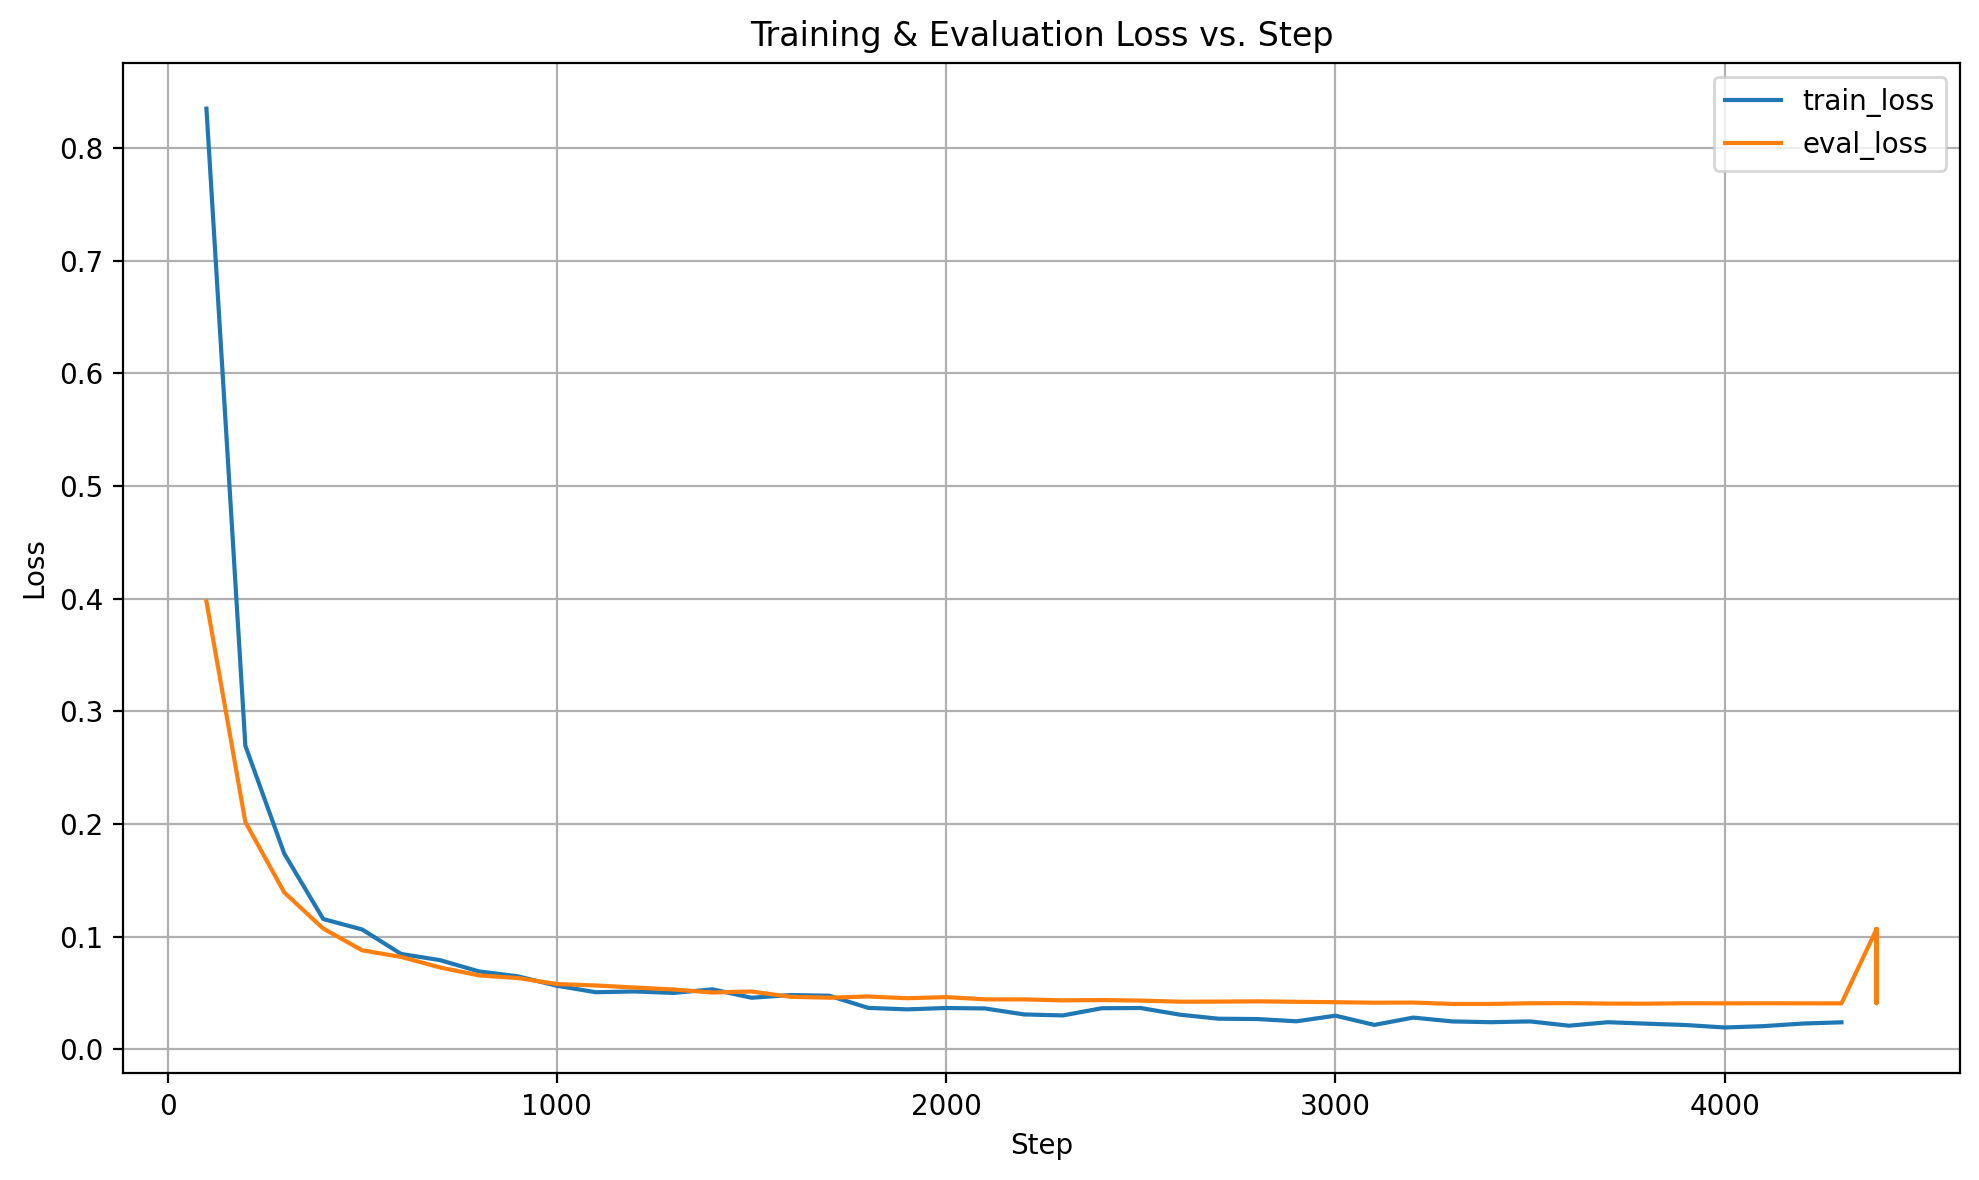

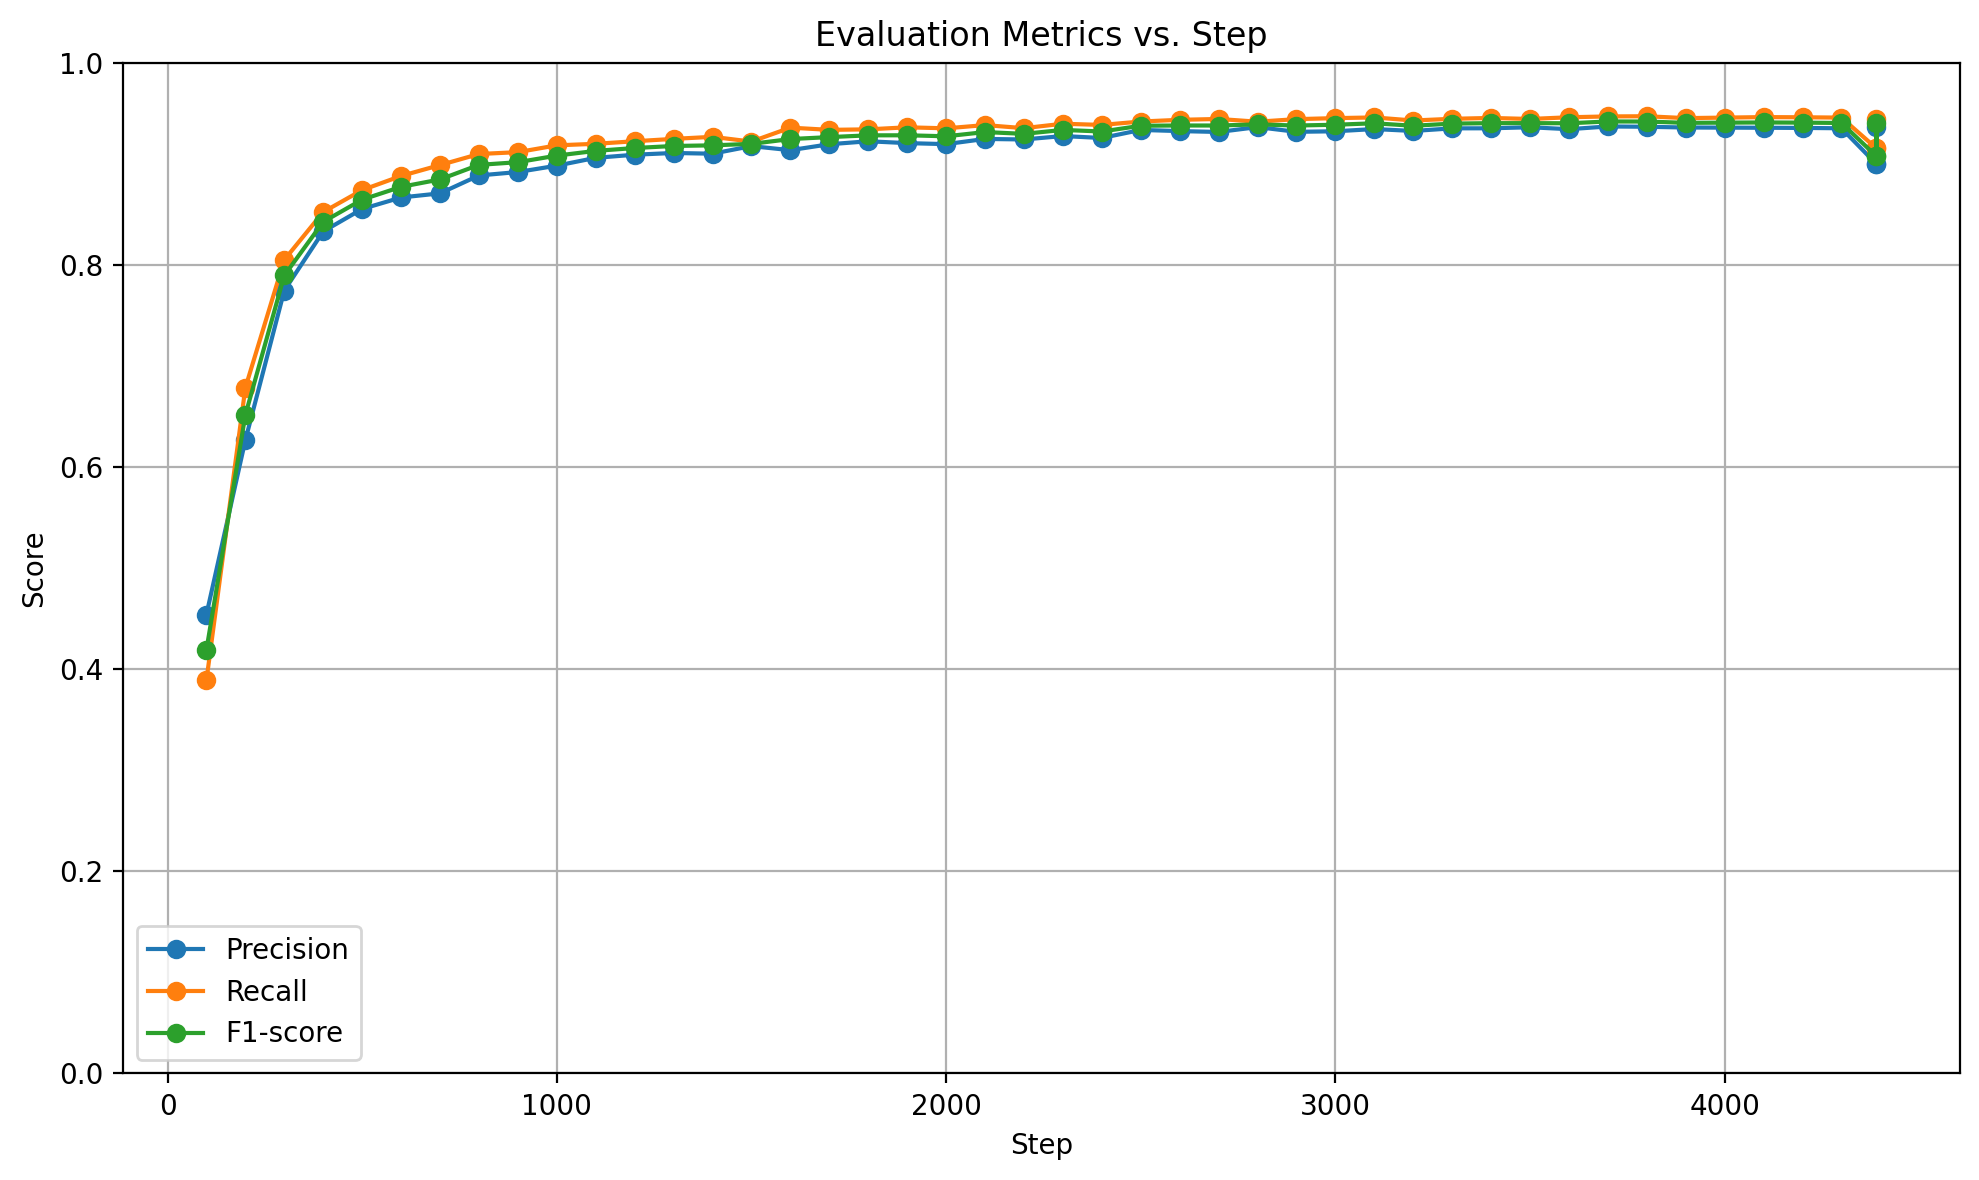

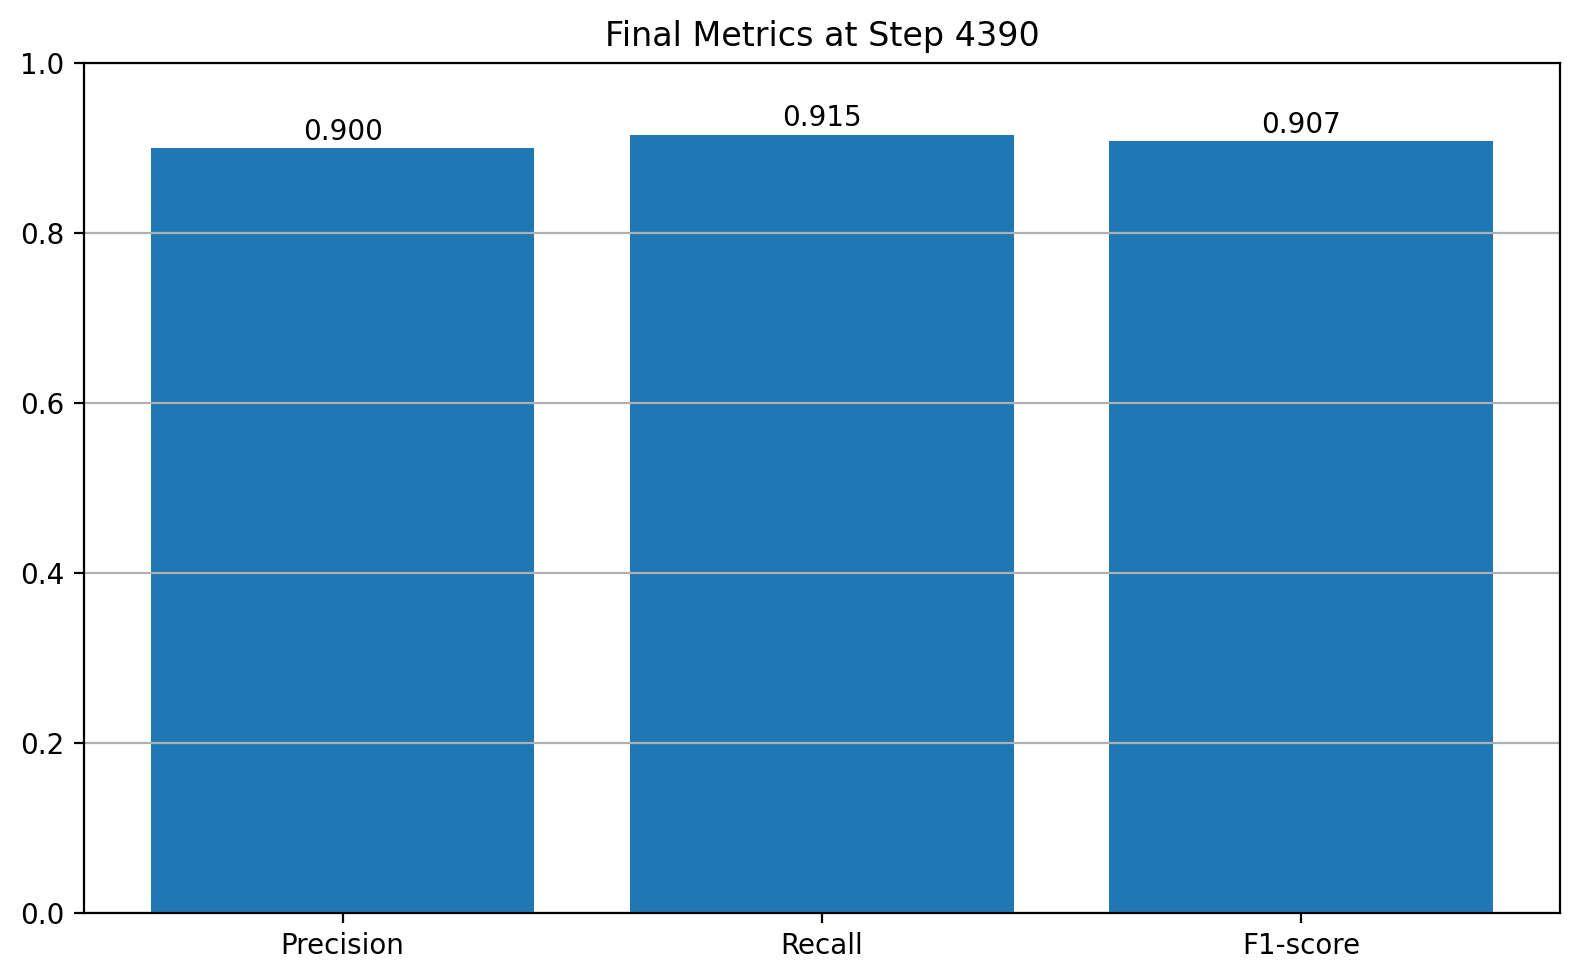

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1) Numeric Results
val_metrics = trainer.evaluate(val_ds)
test_metrics = trainer.evaluate(test_ds)

print("Validation Metrics:")
for k, v in val_metrics.items():
    if k.startswith("eval_"):
        print(f"  {k}: {v:.4f}")

print("\nTest Metrics:")
for k, v in test_metrics.items():
    if k.startswith("eval_"):
        print(f"  {k}: {v:.4f}")

# 2) Visual Results from log_history
history = pd.DataFrame(trainer.state.log_history)

# a) Train & Eval loss vs step
train_loss_df = history[['step', 'loss']].dropna()
eval_df       = history[['step', 'eval_loss', 'eval_precision', 'eval_recall', 'eval_f1']].dropna()

plt.figure(figsize=(10, 6), dpi=200)
plt.plot(train_loss_df['step'], train_loss_df['loss'], label='train_loss', linewidth=1.5)
plt.plot(eval_df['step'],       eval_df['eval_loss'], label='eval_loss',  linewidth=1.5)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training & Evaluation Loss vs. Step')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# b) Precision / Recall / F1 vs step
plt.figure(figsize=(10, 6), dpi=200)
plt.plot(eval_df['step'], eval_df['eval_precision'], marker='o', label='Precision')
plt.plot(eval_df['step'], eval_df['eval_recall'],    marker='o', label='Recall')
plt.plot(eval_df['step'], eval_df['eval_f1'],        marker='o', label='F1-score')
plt.xlabel('Step')
plt.ylabel('Score')
plt.title('Evaluation Metrics vs. Step')
plt.ylim(0, 1.0)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# c) Final-step bar chart
final_step = eval_df['step'].max()
final_row  = eval_df[eval_df['step'] == final_step].iloc[0]
final_scores = {
    'Precision': final_row['eval_precision'],
    'Recall':    final_row['eval_recall'],
    'F1-score':  final_row['eval_f1']
}

plt.figure(figsize=(8, 5), dpi=200)
bars = plt.bar(final_scores.keys(), final_scores.values())
for bar, score in zip(bars, final_scores.values()):
    plt.text(bar.get_x() + bar.get_width()/2, score + 0.01,
             f"{score:.3f}", ha='center')
plt.ylim(0, 1.0)
plt.title(f"Final Metrics at Step {int(final_step)}")
plt.grid(axis='y')
plt.tight_layout()
plt.show()